In [97]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [72]:
price_book = pd.read_csv("Data/simulated_bond_data.csv")
price_book['spread'] = price_book['ask_price'] - price_book['bid_price']

In [73]:
len(price_book)

32400

In [74]:
def estimate_k_and_A(window_df):
    # Bin spreads
    window_df = window_df.copy()
    window_df['spread_bin'] = pd.cut(window_df['spread'], bins=np.arange(0, 0.1, 0.0025))
    
    # Sum volume by spread bin
    volume_by_bin = window_df.groupby('spread_bin', observed=True)['volume'].sum().reset_index()
    volume_by_bin = volume_by_bin[volume_by_bin['volume'] > 0]  # avoid log(0)

    # Use bin midpoints as spread estimates
    volume_by_bin['bin_mid'] = volume_by_bin['spread_bin'].apply(lambda x: x.mid)
    
    X = volume_by_bin['bin_mid'].values
    y = np.log(volume_by_bin['volume'].values)
    
    if len(X) < 2:
        return None, None  # not enough data to fit

    slope, intercept = np.polyfit(X, y, deg=1)
    
    k = -slope
    A = np.exp(intercept)
    
    return k, A / 1000


In [75]:
base_spread = .04
gamma = 0.1

In [116]:
inventory = 0
cash = 0
book = []
trades = []
volume = []

for index, row in tqdm(price_book[1001:].iterrows()):
    # Group spread and volume count to estimate liquidity
    window = price_book.loc[index-1000:index-1]
    k, A = estimate_k_and_A(window)

    # Set bid/ask
    mid = price_book.loc[index - 1, 'mid_price']
    bid = mid - base_spread / 2 - gamma * inventory
    bid = min(mid, bid - .01)

    ask = mid + base_spread / 2 - gamma * inventory
    ask = max(mid, ask + .01)
    # Calculate number of trades
    
    dist_to_bid = abs(mid - bid)
    dist_to_ask = abs(ask - mid)
    lambda_t_bid = .5*A * np.exp(-k * (dist_to_bid))
    lambda_t_ask = .5*A * np.exp(-k * (dist_to_ask))
    num_trades_bid = np.random.poisson(lam=lambda_t_bid)
    num_trades_ask = np.random.poisson(lam=lambda_t_ask)
    volume.append(num_trades_bid + num_trades_ask)

    for _ in range(num_trades_bid):
        inventory += 1
        cash -= bid

    for _ in range(num_trades_ask):
        inventory -= 1
        cash += ask
    trades.append(inventory)
    book.append(cash)

31399it [01:24, 372.50it/s]


In [117]:

cash_df = pd.DataFrame({
    'cash': book,
    'inventory': trades,
    'volume': volume
})


# Simulate timestamps assuming 1-second intervals
cash_df['timestamp'] = pd.date_range(start='2023-01-01 09:00:00', periods=len(book), freq='s')
cash_df.set_index('timestamp', inplace=True)

# Resample over 5-minute intervals (300 seconds)
cash_5min = cash_df['cash'].resample('5min').mean()
book_5min = cash_df['inventory'].resample('20min').mean()
volume_5min = cash_df['volume'].resample('10min').sum()
returns_10m = np.log(cash_5min / cash_5min.shift(1))


c:\Users\Michael\Coding\Python\BondMarketMaking\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


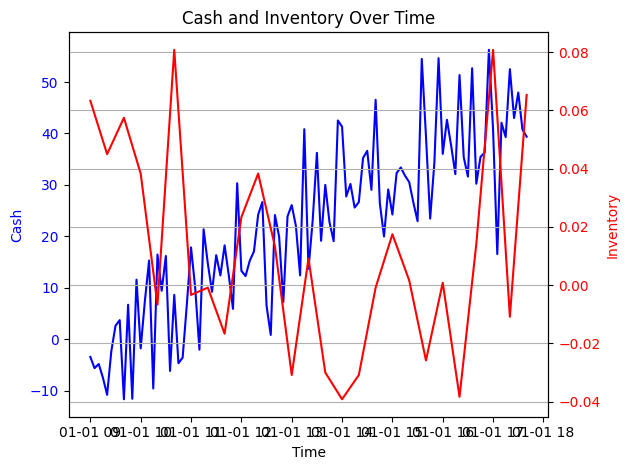

In [118]:

fig, ax1 = plt.subplots()
ax1.set_xlabel('Time')
ax1.set_ylabel('Cash', color='blue')
ax1.plot(cash_5min, color='blue', label='Cash')
ax1.tick_params(axis='y', labelcolor='blue')

# Second y-axis (shared x-axis)
ax2 = ax1.twinx()
ax2.set_ylabel('Inventory', color='red')
ax2.plot(book_5min, color='red', label='Inventory')
ax2.tick_params(axis='y', labelcolor='red')

# Title and layout
plt.title('Cash and Inventory Over Time')
fig.tight_layout()
plt.grid(True)
plt.show()

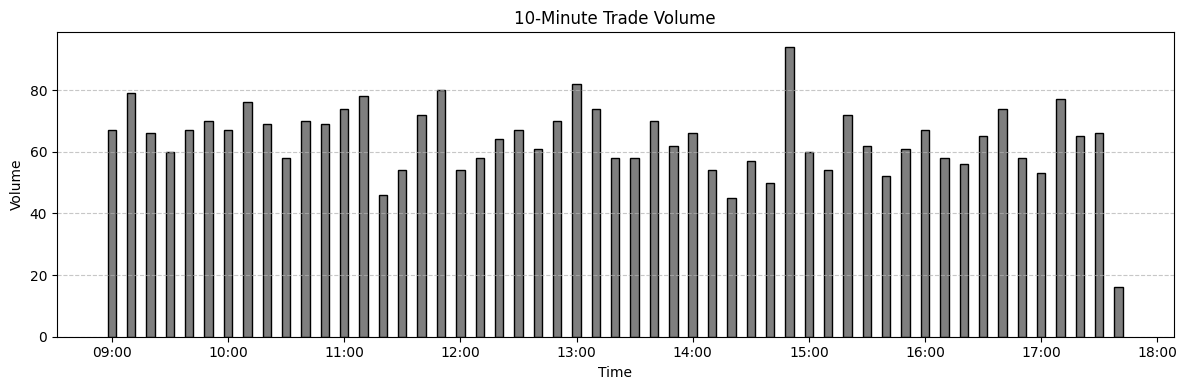

In [119]:
plt.figure(figsize=(12, 4))
plt.bar(volume_5min.index, volume_5min.values, width=0.003, color='tab:gray', edgecolor='black')

# Format x-axis to show only time (HH:MM) every hour
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator())

plt.title('10-Minute Trade Volume')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

<Axes: title={'center': 'Log Returns After 11:00 AM'}, xlabel='timestamp'>

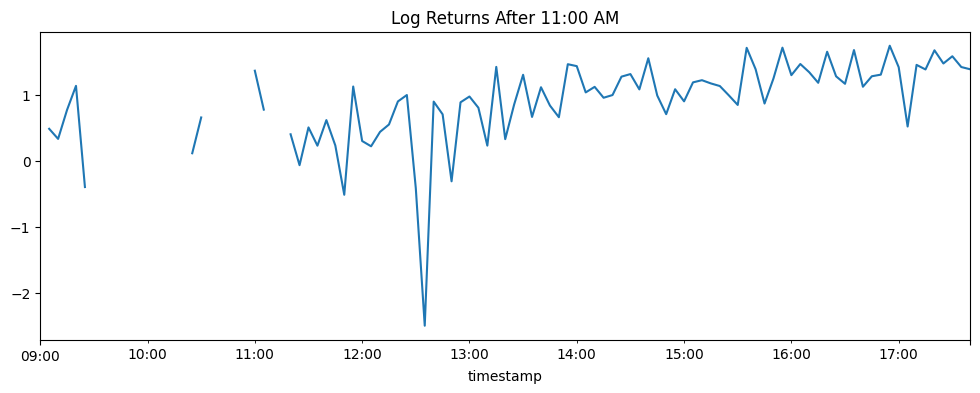

In [ ]:
zoomed_returns = returns_10m[returns_10m.index.time >= pd.to_datetime("8:00").time()]
zoomed_returns.cumsum().fillna(0).plot(figsize=(12, 4), title="Log Returns After 11:00 AM")

# plt.xlabel('Time')
# print(cumsum.tail(10))

In [ ]:
returns

pandas.core.series.Series